In [63]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflowonspark import TFCluster
from sklearn.preprocessing import MinMaxScaler

import os.path
from os import path


# Khởi tạo Spark Session
spark = SparkSession.builder.appName("kafka").getOrCreate()
sc = spark.sparkContext
# Tạo DataFrame mẫu
train_data = spark.read.csv("../data/train_data.csv", inferSchema=True, header=True)
test_data = spark.read.csv("../data/test_data.csv", inferSchema=True, header=True)


In [64]:
# Tao du lieu train, X = 60 time steps, Y =  1 time step
def pre_process(data, data_scaled):
    X=[]
    y=[]
    no_of_sample = len(data)

    for i in range(60, no_of_sample):
        X.append(data_scaled[i-60:i, 0])
        y.append(data_scaled[i, 0])

    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y

In [65]:
def init_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(60, 1)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(1)  # Output layer, có thể điều chỉnh theo yêu cầu
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [66]:
training_set = train_data.select("close").toPandas().values
# Thuc hien scale du lieu gia ve khoang 0,1
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [67]:
X_train, y_train = pre_process(training_set, training_set_scaled)

In [68]:
test_set = test_data.select("close").toPandas().values
test_set_scaled = scaler.transform(test_set)

X_val, y_val = pre_process(test_set, test_set_scaled)

In [69]:
model = init_model()

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
77/77 [==============================] - 1s 5ms/step - loss: 0.0168 - val_loss: 0.0035
Epoch 2/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 3/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 4/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 5/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 6/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 7/100
77/77 [==============================] - 0s 3ms/step - loss: 9.9923e-04 - val_loss: 0.0021
Epoch 8/100
77/77 [==============================] - 0s 3ms/step - loss: 8.9611e-04 - val_loss: 0.0015
Epoch 9/100
77/77 [==============================] - 0s 3ms/step - loss: 9.2477e-04 - val_loss: 0.0012
Epoch 10/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.00

In [70]:
model.save("../model/TCN_model.h5")

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [71]:
# model = init_model()
# model.load_weights("../model/TCN_model.h5")

In [72]:
predictions = model.predict(X_val)

6/6 [==============================] - 0s 1ms/step


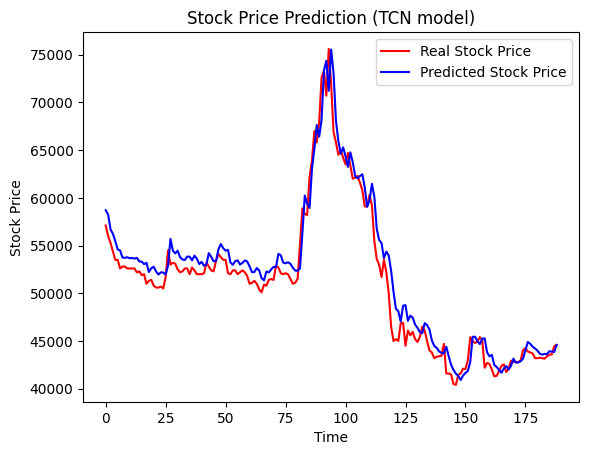

In [73]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(scaler.inverse_transform([[x] for x in y_val]), color = 'red', label = 'Real Stock Price')
plt.plot(scaler.inverse_transform(np.array(predictions)), color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction (TCN model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('../static/tcn_result.jpg')
plt.show()


## Đánh giá

In [78]:
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [76]:
_predictions = scaler.inverse_transform(np.array(predictions))
_Yvar = scaler.inverse_transform([[x] for x in y_val])

In [79]:
# Tính toán MSE
mse = mean_squared_error(_predictions, _Yvar)

# Tính toán RMSE
rmse = np.sqrt(mse)

# Tính toán MAE
mae = mean_absolute_error(_predictions, _Yvar)

# Tính toán R^2
r2 = r2_score(_predictions, _Yvar)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

MSE: 3047087.0930247647
RMSE: 1745.5907576017823
MAE: 1381.0256489748676
R^2: 0.9446130724889218


In [80]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(_predictions, _Yvar)

print(f'MAPE: {mape}')

MAPE: 2.5946010298558213


## test

In [13]:
from keras.models import Sequential
from tcn import TCN
from keras.layers import Dense

In [25]:
model = Sequential([
    TCN(input_shape=(60, 1)),
    Dense(units=1, activation='softmax')
])

In [26]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
77/77 [==============================] - 4s 28ms/step - loss: 2.7753 - val_loss: 0.0109
Epoch 2/100
77/77 [==============================] - 2s 25ms/step - loss: 0.0053 - val_loss: 0.0118
Epoch 3/100
77/77 [==============================] - 2s 25ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 4/100
77/77 [==============================] - 2s 26ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 5/100
77/77 [==============================] - 2s 24ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 6/100
77/77 [==============================] - 2s 24ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 7/100
77/77 [==============================] - 2s 27ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 8/100
77/77 [==============================] - 2s 29ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/100
77/77 [==============================] - 2s 26ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 10/100
77/77 [==============================] - 3s 44ms/step - loss: 0.0024 - val_loss: 0.0022

In [28]:
predictions = model.predict(X_val)

6/6 [==============================] - 0s 8ms/step


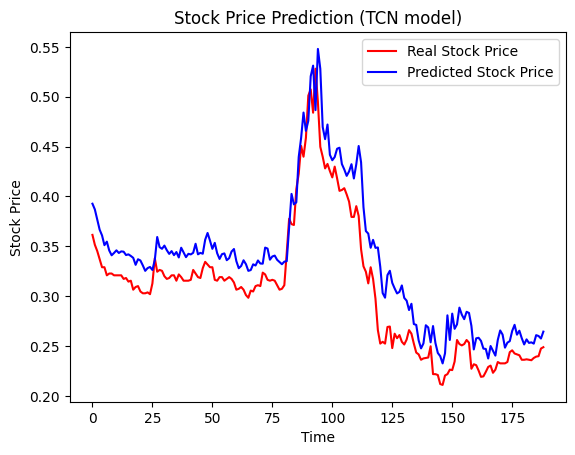

In [29]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(y_val, color = 'red', label = 'Real Stock Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction (TCN model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.savefig('../static/tcn_result.jpg')
plt.show()

In [7]:
train_data.select("open", "high", "low", "close", "volume").toPandas()

,open,high,low,close,volume
0,16876,17407,16770,16982,106720
1,16982,16982,16770,16982,118830
2,16876,17088,16770,16982,162880
3,17088,17831,17088,17725,370650
4,17937,18044,17725,17937,363210
...,...,...,...,...,...
2491,52900,53000,52300,52900,317300
2492,52900,54800,52100,53400,1844000
2493,53500,53500,52100,53500,2089000
2494,53200,54000,52500,53600,2135400


In [27]:
data = train_data.select("open", "high", "low", "close", "volume").toPandas().values

In [73]:
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(data)

In [75]:
X=[]
y=[]
no_of_sample = len(training_set_scaled)

for i in range(60, no_of_sample):
    X.append(training_set_scaled[i-60:i])
    y.append(training_set_scaled[i][3])

X, y = np.array(X), np.array(y)

# X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [76]:
X.shape

(2436, 60, 5)

In [48]:
y.shape

(2436,)

In [15]:
training_set = train_data.select("close").toPandas().values
# Thuc hien scale du lieu gia ve khoang 0,1
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [22]:
X_train, y_train = pre_process(training_set, training_set_scaled)

In [45]:
test_set = test_data.select("close").toPandas().values
test_set_scaled = scaler.transform(test_set)

X_val, y_val = pre_process(test_set, test_set_scaled)

In [46]:
# test_set = test_data.select("close").toPandas().values
# a = training_set[len(training_set)-60:]
# dataset_test = np.concatenate((a, test_set), axis=0)
# # Thuc hien scale du lieu gia ve khoang 0,1
# test_set_scaled = scaler.transform(dataset_test)

In [47]:
# X_val, y_val = pre_process(dataset_test, test_set_scaled)

In [48]:
len(y_val)

189

In [77]:
def init_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(60, 5)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(1)  # Output layer, có thể điều chỉnh theo yêu cầu
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [93]:
model = init_model()

model.fit(X, y, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
77/77 [==============================] - 1s 4ms/step - loss: 0.0157 - val_loss: 0.0019
Epoch 2/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 4/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 5/100
77/77 [==============================] - 0s 3ms/step - loss: 9.4834e-04 - val_loss: 0.0063
Epoch 6/100
77/77 [==============================] - 0s 3ms/step - loss: 8.4577e-04 - val_loss: 0.0061
Epoch 7/100
77/77 [==============================] - 0s 3ms/step - loss: 8.6074e-04 - val_loss: 0.0050
Epoch 8/100
77/77 [==============================] - 0s 3ms/step - loss: 8.3913e-04 - val_loss: 0.0046
Epoch 9/100
77/77 [==============================] - 0s 3ms/step - loss: 7.4573e-04 - val_loss: 0.0052
Epoch 10/100
77/77 [==============================] - 0s 3ms/step - loss: 5.4817e-04 - va

In [79]:
dataval = test_data.select("open", "high", "low", "close", "volume").toPandas().values

In [72]:
test_data.select("open", "high", "low", "close", "volume").toPandas()

,open,high,low,close,volume
0,53800,56800,53400,56800,2009300
1,56900,57100,55900,56000,1928400
2,56100,56900,55800,56200,1641900
3,56000,56100,54900,56100,1951000
4,56200,56200,55000,55000,1204200
...,...,...,...,...,...
244,43100,43550,43000,43400,1977500
245,43400,43750,43350,43550,1763700
246,43650,43950,43600,43600,1848500
247,43600,44600,43600,44450,4070700


In [80]:
# scaler = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = scaler.transform(dataval)

In [81]:
X_val=[]
y_val=[]
no_of_sample = len(test_set_scaled)

for i in range(60, no_of_sample):
    X_val.append(test_set_scaled[i-60:i])
    y_val.append(test_set_scaled[i][3])

X_val, y_val = np.array(X_val), np.array(y_val)

In [94]:
predictions = model.predict(X_val)

6/6 [==============================] - 0s 1ms/step


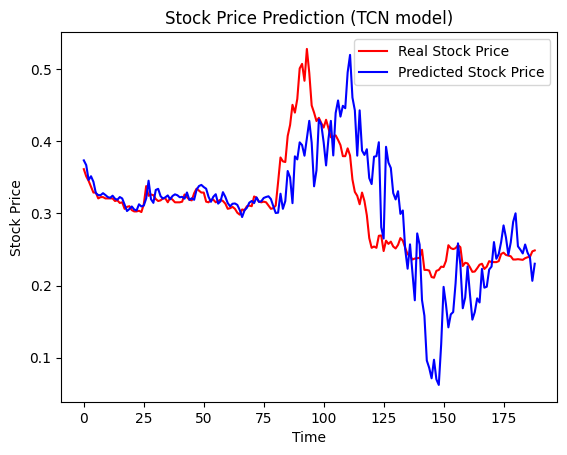

In [95]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(y_val, color = 'red', label = 'Real Stock Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction (TCN model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('../static/tcn_result.jpg')
plt.show()


In [96]:
predictions = model.predict(X)

77/77 [==============================] - 0s 1ms/step


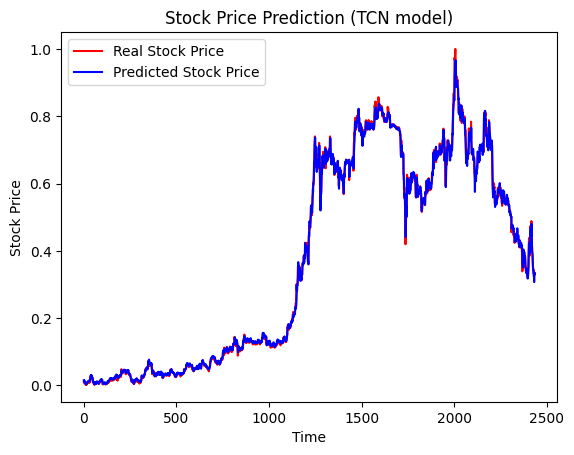

In [97]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(y, color = 'red', label = 'Real Stock Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction (TCN model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('../static/tcn_result.jpg')
plt.show()

In [50]:
model = init_model()

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100


77/77 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0044
Epoch 2/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 3/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 4/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 5/100
77/77 [==============================] - 0s 3ms/step - loss: 8.6487e-04 - val_loss: 0.0016
Epoch 6/100
77/77 [==============================] - 0s 3ms/step - loss: 7.9693e-04 - val_loss: 0.0014
Epoch 7/100
77/77 [==============================] - 0s 3ms/step - loss: 6.5391e-04 - val_loss: 8.2670e-04
Epoch 8/100
77/77 [==============================] - 0s 3ms/step - loss: 6.1329e-04 - val_loss: 9.0847e-04
Epoch 9/100
77/77 [==============================] - 0s 3ms/step - loss: 5.4132e-04 - val_loss: 7.5927e-04
Epoch 10/100
77/77 [==============================] - 0s 4ms/step - loss: 4.5563e-04 - va

In [51]:
model.save("../model/TCN_model.h5")

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
predictions = model.predict(X_val)

6/6 [==============================] - 0s 1ms/step


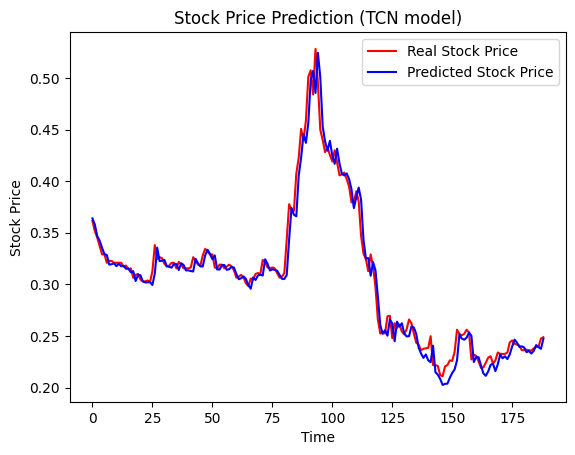

In [53]:
import matplotlib.pyplot as plt

# Ve bieu do gia that va gia du doan
plt.plot(y_val, color = 'red', label = 'Real Stock Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction (TCN model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('../static/tcn_result.jpg')
plt.show()
